In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Basic Regression: Predict fuel efficiency

In a regression problem, we aim to predict the output of a continuous value, like a price or a probability. Contrast this with a classification problem, where we aim to select a class from a list of classes (for example, where a picture contains an apple or an orange, recognizing which fruit is in the picture).

This notebook uses the classic [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) Dataset and builds a model to predict the fuel efficiency of late-1970s and early 1980s automobiles. To do this, we'll provide the model with a description of many automobiles from that time period. This description includes attributes like: cylinders, displacement, horsepower, and weight.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [4]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

#from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2023-02-09 17:09:17.945424: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-09 17:09:17.948025: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-09 17:09:17.948033: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


2.9.1


## The Auto MPG Dataset

In [5]:
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
               'Acceleration', 'Model_Year', 'Origin']

raw_dataset = pd.read_csv('auto-mpg.data', names=column_names,
                         na_values='?', comment='\t',
                         sep=' ', skipinitialspace=True)

In [6]:
raw_dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model_Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [7]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model_Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### Clean the data

In [8]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model_Year      0
Origin          0
dtype: int64

In [9]:
dataset = dataset.dropna()

In [10]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           392 non-null    float64
 1   Cylinders     392 non-null    int64  
 2   Displacement  392 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        392 non-null    float64
 5   Acceleration  392 non-null    float64
 6   Model_Year    392 non-null    int64  
 7   Origin        392 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 27.6 KB


The `"Origin"` column is really categorical, not numeric. So convert that to a one-hot

In [11]:
dataset['Origin'] = dataset['Origin'].map({1:'USA', 2:'Europ', 3:'Japan'})

In [12]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model_Year,Europ,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


## Split Dataset

In [13]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [14]:
train_dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model_Year,Europ,Japan,USA
146,28.0,4,90.0,75.0,2125.0,14.5,74,0,0,1
282,22.3,4,140.0,88.0,2890.0,17.3,79,0,0,1
69,12.0,8,350.0,160.0,4456.0,13.5,72,0,0,1
378,38.0,4,105.0,63.0,2125.0,14.7,82,0,0,1
331,33.8,4,97.0,67.0,2145.0,18.0,80,0,1,0
...,...,...,...,...,...,...,...,...,...,...
281,19.8,6,200.0,85.0,2990.0,18.2,79,0,0,1
229,16.0,8,400.0,180.0,4220.0,11.1,77,0,0,1
150,26.0,4,108.0,93.0,2391.0,15.5,74,0,1,0
145,32.0,4,83.0,61.0,2003.0,19.0,74,0,1,0


In [15]:
test_dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model_Year,Europ,Japan,USA
9,15.0,8,390.0,190.0,3850.0,8.5,70,0,0,1
25,10.0,8,360.0,215.0,4615.0,14.0,70,0,0,1
28,9.0,8,304.0,193.0,4732.0,18.5,70,0,0,1
31,25.0,4,113.0,95.0,2228.0,14.0,71,0,1,0
33,19.0,6,232.0,100.0,2634.0,13.0,71,0,0,1
...,...,...,...,...,...,...,...,...,...,...
369,34.0,4,112.0,88.0,2395.0,18.0,82,0,0,1
375,36.0,4,105.0,74.0,1980.0,15.3,82,1,0,0
382,34.0,4,108.0,70.0,2245.0,16.9,82,0,1,0
384,32.0,4,91.0,67.0,1965.0,15.7,82,0,1,0


## Inspect the data

Looking at the top row it should be clear that the fuel efficiency (MPG) is a function of all the other parameters. Looking at the other rows it should be clear that they are each functions of eachother.

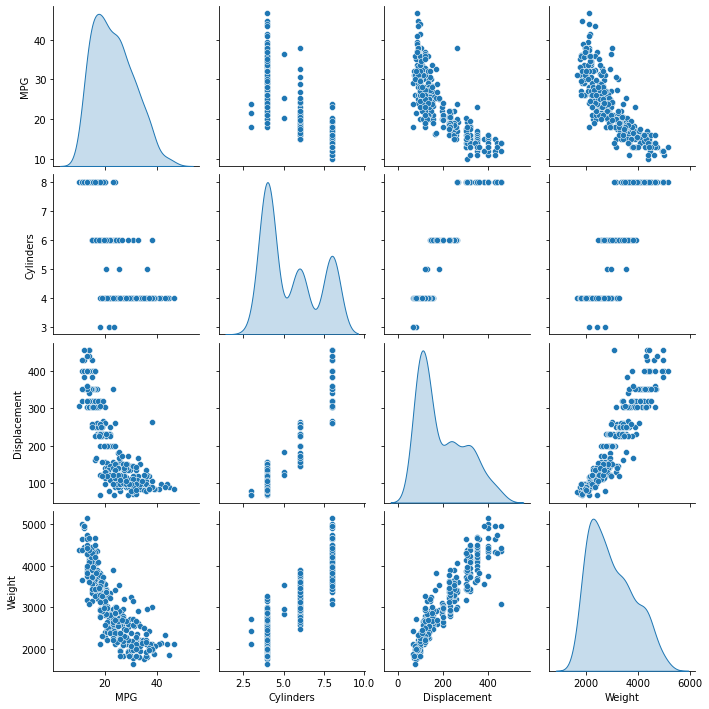

In [16]:
sns.pairplot(train_dataset[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

Also look at the overall statistics, note how each feature covers a very different range:

In [17]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model_Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europ,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


## Split features from labels

In [18]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

In [19]:
train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

In [20]:
train_features

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model_Year,Europ,Japan,USA
146,4,90.0,75.0,2125.0,14.5,74,0,0,1
282,4,140.0,88.0,2890.0,17.3,79,0,0,1
69,8,350.0,160.0,4456.0,13.5,72,0,0,1
378,4,105.0,63.0,2125.0,14.7,82,0,0,1
331,4,97.0,67.0,2145.0,18.0,80,0,1,0
...,...,...,...,...,...,...,...,...,...
281,6,200.0,85.0,2990.0,18.2,79,0,0,1
229,8,400.0,180.0,4220.0,11.1,77,0,0,1
150,4,108.0,93.0,2391.0,15.5,74,0,1,0
145,4,83.0,61.0,2003.0,19.0,74,0,1,0


In [21]:
test_features

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model_Year,Europ,Japan,USA
9,8,390.0,190.0,3850.0,8.5,70,0,0,1
25,8,360.0,215.0,4615.0,14.0,70,0,0,1
28,8,304.0,193.0,4732.0,18.5,70,0,0,1
31,4,113.0,95.0,2228.0,14.0,71,0,1,0
33,6,232.0,100.0,2634.0,13.0,71,0,0,1
...,...,...,...,...,...,...,...,...,...
369,4,112.0,88.0,2395.0,18.0,82,0,0,1
375,4,105.0,74.0,1980.0,15.3,82,1,0,0
382,4,108.0,70.0,2245.0,16.9,82,0,1,0
384,4,91.0,67.0,1965.0,15.7,82,0,1,0


In [22]:
train_labels

146    28.0
282    22.3
69     12.0
378    38.0
331    33.8
       ... 
281    19.8
229    16.0
150    26.0
145    32.0
182    28.0
Name: MPG, Length: 314, dtype: float64

In [23]:
test_labels

9      15.0
25     10.0
28      9.0
31     25.0
33     19.0
       ... 
369    34.0
375    36.0
382    34.0
384    32.0
396    28.0
Name: MPG, Length: 78, dtype: float64

In [24]:
train_features.shape

(314, 9)

## Normalization

In [25]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model_Year,75.898089,3.675642
Europ,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


### Normalization Layer

The `preprocessing.Normalization` layer is a clean and simple way to build that preprocessing into your model.

The first step is to create the layer:

In [26]:
normalizer = layers.Normalization()

Then `.adapt()` it to the data:

In [27]:
normalizer.adapt(np.array(train_features))

2023-02-09 17:09:20.187041: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-09 17:09:20.187058: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-09 17:09:20.187069: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nsl54): /proc/driver/nvidia/version does not exist
2023-02-09 17:09:20.187232: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [28]:
print(normalizer.mean.numpy())

[[5.47770691e+00 1.95318497e+02 1.04869446e+02 2.99025171e+03
  1.55592356e+01 7.58980942e+01 1.78343967e-01 1.97452217e-01
  6.24203861e-01]]


When the layer is called it returns the input data, with each feature independently normalized:

In [29]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
    print('First example:', first)
    print()
    print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


## Linear Regression

### One Variable

Start with a single-variable linear regression, to predict `MPG` from `Horsepower`.

Training a model with `tf.keras` typically starts by defining the model architecture.

In this case use a `keras.Sequential` model. This model represents a sequence of steps. In this case there are two steps:

* Normalize the input `horsepower`.
* Apply a linear transformation ($y = mx+b$) to produce 1 output using `layers.Dense`.

The number of _inputs_ can either be set by the `input_shape` argument, or automatically when the model is run for the first time.

First create the horsepower `Normalization` layer:

In [30]:
horsepower = np.array(train_features["Horsepower"])
horsepower

array([ 75.,  88., 160.,  63.,  67.,  90.,  60.,  67.,  95.,  88.,  60.,
       180.,  88., 150., 155.,  75., 115., 150.,  90.,  90., 129., 110.,
        90., 110.,  76., 165.,  92.,  88., 100., 150., 122.,  74.,  76.,
        67., 110.,  90.,  65., 150., 150., 220., 165.,  67.,  75., 140.,
        78., 149.,  84., 150., 145., 100.,  75., 170., 200.,  72.,  78.,
        76.,  88., 105.,  53.,  86.,  95.,  75.,  71., 198.,  69., 105.,
       215.,  88.,  87.,  65.,  60.,  68., 129., 145.,  95., 153.,  70.,
       145.,  68.,  70., 100.,  70.,  81.,  95., 225.,  90.,  97., 100.,
        65., 110.,  89., 150., 110.,  95.,  85.,  97.,  60.,  88.,  52.,
        70., 198.,  71.,  90.,  72.,  63., 115.,  90., 135.,  52., 150.,
       170.,  58.,  96., 125.,  92.,  95.,  90.,  95.,  82., 110.,  78.,
        67., 208., 105., 130., 150.,  46.,  90.,  64.,  75.,  85.,  72.,
        95.,  90., 145.,  88., 167., 120., 190.,  78.,  49.,  86., 150.,
        70., 107.,  80., 150., 105., 100., 145.,  8

In [31]:
horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)

horsepower_normalizer.adapt(horsepower)

Building the Sequential model:

In [32]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


This model will predict `MPG` from `Horsepower`.

Run the untrained model on the first 10 horse-power values. The output won't be good, but you'll see that it has the expected shape, `(10,1)`:

In [33]:
horsepower_model.predict(horsepower[:10])

1/1 [==============================] - 0s 44ms/step


array([[ 1.2440566 ],
       [ 0.7026091 ],
       [-2.2961767 ],
       [ 1.7438543 ],
       [ 1.577255  ],
       [ 0.6193095 ],
       [ 1.8688036 ],
       [ 1.577255  ],
       [ 0.41106048],
       [ 0.7026091 ]], dtype=float32)

Once the model is built, configure the training procedure using the `Model.compile()` method. The most important arguments to compile are the `loss` and the `optimizer` since these define what will be optimized (`mean_absolute_error`) and how (using the `optimizers.Adam`).

In [34]:
horsepower_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1),
                        loss='mean_absolute_error')

Once the training is configured, use `Model.fit()` to execute the training:

In [35]:
%%time
history = horsepower_model.fit(train_features['Horsepower'], train_labels,
                              epochs=100,
                              verbose=1,
                              validation_split=0.2)

Epoch 1/100
8/8 [==============================] - 0s 11ms/step - loss: 22.8669 - val_loss: 22.9306
Epoch 2/100
8/8 [==============================] - 0s 3ms/step - loss: 22.0634 - val_loss: 22.1305
Epoch 3/100
8/8 [==============================] - 0s 2ms/step - loss: 21.2643 - val_loss: 21.3307
Epoch 4/100
8/8 [==============================] - 0s 2ms/step - loss: 20.4634 - val_loss: 20.5306
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 19.6643 - val_loss: 19.7305
Epoch 6/100
8/8 [==============================] - 0s 2ms/step - loss: 18.8643 - val_loss: 18.9307
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 18.0692 - val_loss: 18.1304
Epoch 8/100
8/8 [==============================] - 0s 3ms/step - loss: 17.2646 - val_loss: 17.3305
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 16.4628 - val_loss: 16.5308
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 15.6629 - val_loss: 15.7308
Epoch 11

8/8 [==============================] - 0s 2ms/step - loss: 3.8039 - val_loss: 4.1977
Epoch 85/100
8/8 [==============================] - 0s 2ms/step - loss: 3.8033 - val_loss: 4.1824
Epoch 86/100
8/8 [==============================] - 0s 2ms/step - loss: 3.8037 - val_loss: 4.1908
Epoch 87/100
8/8 [==============================] - 0s 2ms/step - loss: 3.8020 - val_loss: 4.1921
Epoch 88/100
8/8 [==============================] - 0s 2ms/step - loss: 3.8069 - val_loss: 4.1932
Epoch 89/100
8/8 [==============================] - 0s 2ms/step - loss: 3.8064 - val_loss: 4.1861
Epoch 90/100
8/8 [==============================] - 0s 2ms/step - loss: 3.8021 - val_loss: 4.1892
Epoch 91/100
8/8 [==============================] - 0s 2ms/step - loss: 3.8046 - val_loss: 4.1936
Epoch 92/100
8/8 [==============================] - 0s 2ms/step - loss: 3.8034 - val_loss: 4.1958
Epoch 93/100
8/8 [==============================] - 0s 2ms/step - loss: 3.8013 - val_loss: 4.1728
Epoch 94/100
8/8 [===============

**Visualize the model's training progress using the stats stored in the `history` object.**

In [36]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.801712,4.198673,95
96,3.804620,4.194077,96
97,3.804587,4.197507,97
98,3.803183,4.178868,98
99,3.805135,4.172251,99


In [37]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch', color='white')
    plt.ylabel('Error [MPG]', color='white')
    plt.legend()
    plt.grid(True)
    plt.show()

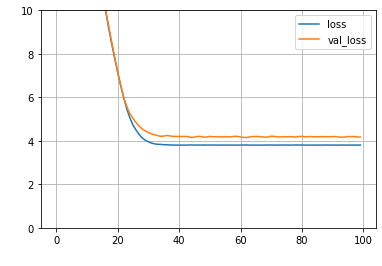

In [38]:
plot_loss(history)

Collect the results on the test set, for later:

In [39]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(test_features['Horsepower'],
                                                            test_labels, verbose=1)

3/3 [==============================] - 0s 932us/step - loss: 3.6560


Since this is a single variable regression it's easy to look at the model's predictions as a function of the input:

In [40]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)
print('x\n',x)
print()
print('y\n',y)

8/8 [==============================] - 0s 626us/step
x
 tf.Tensor(
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.
  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.
  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.
  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.
  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.
  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111.
 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125.
 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181.
 182. 183.

In [41]:
def plot_horsepower(x, y):
    plt.scatter(train_features['Horsepower'], train_labels, label='Data', color='b')
    plt.plot(x, y, color='r', label='Predictions')
    plt.xlabel('Horsepower', color='white')
    plt.ylabel('MPG', color='white')
    plt.legend()
    plt.show()

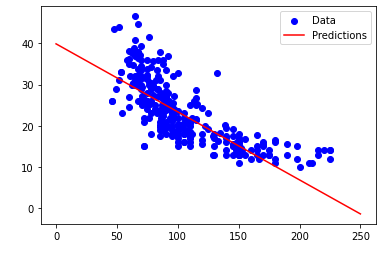

In [42]:
plot_horsepower(x, y)

## Multiple inputs

You can use an almost identical setup to make predictions based on multiple inputs. This model still does the same $y = mx+b$ except that $m$ is a matrix and $b$ is a vector.

This time use the `Normalization` layer that was adapted to the whole dataset.

In [43]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [44]:
linear_model.predict(train_features[:10])

1/1 [==============================] - 0s 26ms/step


array([[ 0.3778852 ],
       [-0.09180605],
       [-1.0374745 ],
       [ 0.21571001],
       [-0.2964157 ],
       [ 0.05811925],
       [-0.10566199],
       [ 1.7037828 ],
       [ 0.016004  ],
       [-0.24478674]], dtype=float32)

When you call the model it's weight matrices will be built. Now you can see that the `kernel` (the $m$ in $y=mx+b$) has a shape of `(9,1)`.

In [45]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[-0.24491179],
       [ 0.6939001 ],
       [-0.53830105],
       [-0.51763535],
       [ 0.12613356],
       [-0.20229137],
       [ 0.7412914 ],
       [-0.09715146],
       [ 0.19644338]], dtype=float32)>

In [46]:
linear_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1),
                    loss='mean_absolute_error')

In [47]:
%%time
history = linear_model.fit(train_features, train_labels,
                          epochs=100,
                          verbose=1,
                          validation_split=0.2)

Epoch 1/100
8/8 [==============================] - 0s 19ms/step - loss: 22.9636 - val_loss: 22.9001
Epoch 2/100
8/8 [==============================] - 0s 3ms/step - loss: 22.0797 - val_loss: 22.2104
Epoch 3/100
8/8 [==============================] - 0s 3ms/step - loss: 21.2687 - val_loss: 21.4934
Epoch 4/100
8/8 [==============================] - 0s 3ms/step - loss: 20.4354 - val_loss: 20.7800
Epoch 5/100
8/8 [==============================] - 0s 2ms/step - loss: 19.6222 - val_loss: 20.0565
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 18.8052 - val_loss: 19.3062
Epoch 7/100
8/8 [==============================] - 0s 2ms/step - loss: 17.9779 - val_loss: 18.6075
Epoch 8/100
8/8 [==============================] - 0s 4ms/step - loss: 17.1408 - val_loss: 17.8895
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 16.3445 - val_loss: 17.2259
Epoch 10/100
8/8 [==============================] - 0s 2ms/step - loss: 15.5437 - val_loss: 16.4879
Epoch 11

8/8 [==============================] - 0s 2ms/step - loss: 2.4711 - val_loss: 2.4940
Epoch 85/100
8/8 [==============================] - 0s 2ms/step - loss: 2.4784 - val_loss: 2.4806
Epoch 86/100
8/8 [==============================] - 0s 2ms/step - loss: 2.4877 - val_loss: 2.4516
Epoch 87/100
8/8 [==============================] - 0s 2ms/step - loss: 2.4781 - val_loss: 2.5169
Epoch 88/100
8/8 [==============================] - 0s 2ms/step - loss: 2.4816 - val_loss: 2.4570
Epoch 89/100
8/8 [==============================] - 0s 2ms/step - loss: 2.5290 - val_loss: 2.4538
Epoch 90/100
8/8 [==============================] - 0s 2ms/step - loss: 2.4710 - val_loss: 2.4819
Epoch 91/100
8/8 [==============================] - 0s 2ms/step - loss: 2.4737 - val_loss: 2.4566
Epoch 92/100
8/8 [==============================] - 0s 2ms/step - loss: 2.4786 - val_loss: 2.4794
Epoch 93/100
8/8 [==============================] - 0s 2ms/step - loss: 2.4832 - val_loss: 2.4840
Epoch 94/100
8/8 [===============

Using all the inputs achieves a much lower training and validation error than the `horsepower` model: 

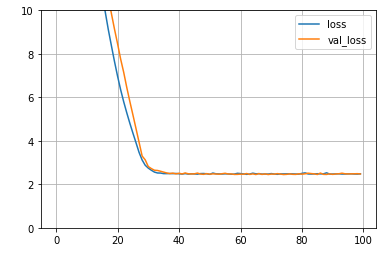

In [48]:
plot_loss(history)

Collect the results on the test set, for later:

In [49]:
test_results['linear_model'] = linear_model.evaluate(test_features, test_labels, verbose=1)

3/3 [==============================] - 0s 911us/step - loss: 2.5147


In [50]:
print(test_results)

{'horsepower_model': 3.655986785888672, 'linear_model': 2.5146825313568115}


## A DNN regression

This section implements single-input and multiple-input DNN models. The code is basically the same except the model is expanded to include some "hidden" non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

* The normalization layer.
* Two hidden, nonlinear, `Dense` layers using the `relu` nonlinearity.
* A linear single-output layer.

Both will use the same training procedure so the `compile` method is included in the `build_and_compile_model` function below.

In [51]:
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    
    model.compile(loss='mean_absolute_error',
                 optimizer=tf.keras.optimizers.Adam(0.001))
    
    return model

### One variable

In [52]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

In [53]:
dnn_horsepower_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                128       
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


## Train

In [54]:
%%time
history = dnn_horsepower_model.fit(train_features['Horsepower'], train_labels,
                                  validation_split=0.2,
                                  verbose=1, epochs=100)

Epoch 1/100
8/8 [==============================] - 0s 10ms/step - loss: 22.8806 - val_loss: 23.2075
Epoch 2/100
8/8 [==============================] - 0s 2ms/step - loss: 22.5710 - val_loss: 22.8373
Epoch 3/100
8/8 [==============================] - 0s 3ms/step - loss: 22.1984 - val_loss: 22.3883
Epoch 4/100
8/8 [==============================] - 0s 3ms/step - loss: 21.7161 - val_loss: 21.8299
Epoch 5/100
8/8 [==============================] - 0s 3ms/step - loss: 21.1377 - val_loss: 21.1040
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 20.3624 - val_loss: 20.1977
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 19.4265 - val_loss: 19.1800
Epoch 8/100
8/8 [==============================] - 0s 3ms/step - loss: 18.4408 - val_loss: 18.0885
Epoch 9/100
8/8 [==============================] - 0s 3ms/step - loss: 17.3363 - val_loss: 17.0270
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 16.1009 - val_loss: 15.9354
Epoch 11

8/8 [==============================] - 0s 2ms/step - loss: 3.2559 - val_loss: 3.7890
Epoch 85/100
8/8 [==============================] - 0s 2ms/step - loss: 3.2550 - val_loss: 3.7804
Epoch 86/100
8/8 [==============================] - 0s 2ms/step - loss: 3.2537 - val_loss: 3.7854
Epoch 87/100
8/8 [==============================] - 0s 2ms/step - loss: 3.2584 - val_loss: 3.7866
Epoch 88/100
8/8 [==============================] - 0s 2ms/step - loss: 3.2517 - val_loss: 3.7780
Epoch 89/100
8/8 [==============================] - 0s 2ms/step - loss: 3.2757 - val_loss: 3.7507
Epoch 90/100
8/8 [==============================] - 0s 2ms/step - loss: 3.2658 - val_loss: 3.7928
Epoch 91/100
8/8 [==============================] - 0s 2ms/step - loss: 3.2580 - val_loss: 3.7861
Epoch 92/100
8/8 [==============================] - 0s 2ms/step - loss: 3.2626 - val_loss: 3.7779
Epoch 93/100
8/8 [==============================] - 0s 2ms/step - loss: 3.2627 - val_loss: 3.7794
Epoch 94/100
8/8 [===============

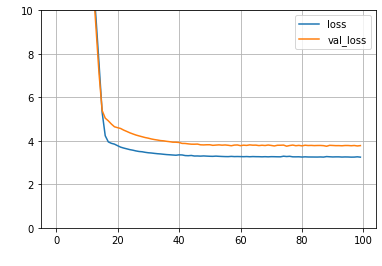

In [55]:
plot_loss(history)

In [56]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

8/8 [==============================] - 0s 591us/step


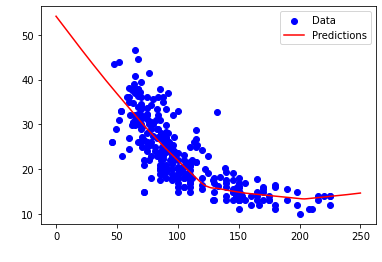

In [57]:
plot_horsepower(x, y)

In [58]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(test_features['Horsepower'], test_labels,
                                                                    verbose=1)

3/3 [==============================] - 0s 993us/step - loss: 2.8904


### Full model

In [59]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 9)                19        
 n)                                                              
                                                                 
 dense_5 (Dense)             (None, 64)                640       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,884
Trainable params: 4,865
Non-trainable params: 19
_________________________________________________________________


In [60]:
%%time
history = dnn_model.fit(train_features, train_labels,
                       validation_split=0.2, verbose=1, epochs=100)

Epoch 1/100
8/8 [==============================] - 0s 10ms/step - loss: 23.1966 - val_loss: 23.4522
Epoch 2/100
8/8 [==============================] - 0s 3ms/step - loss: 22.7143 - val_loss: 22.9524
Epoch 3/100
8/8 [==============================] - 0s 3ms/step - loss: 22.2183 - val_loss: 22.3613
Epoch 4/100
8/8 [==============================] - 0s 3ms/step - loss: 21.6087 - val_loss: 21.6049
Epoch 5/100
8/8 [==============================] - 0s 3ms/step - loss: 20.8045 - val_loss: 20.5988
Epoch 6/100
8/8 [==============================] - 0s 3ms/step - loss: 19.7401 - val_loss: 19.2491
Epoch 7/100
8/8 [==============================] - 0s 3ms/step - loss: 18.3209 - val_loss: 17.4675
Epoch 8/100
8/8 [==============================] - 0s 3ms/step - loss: 16.4372 - val_loss: 15.1610
Epoch 9/100
8/8 [==============================] - 0s 2ms/step - loss: 14.1141 - val_loss: 12.6602
Epoch 10/100
8/8 [==============================] - 0s 3ms/step - loss: 11.6831 - val_loss: 10.1546
Epoch 11

8/8 [==============================] - 0s 3ms/step - loss: 1.6993 - val_loss: 2.0953
Epoch 85/100
8/8 [==============================] - 0s 2ms/step - loss: 1.6823 - val_loss: 2.0798
Epoch 86/100
8/8 [==============================] - 0s 3ms/step - loss: 1.6990 - val_loss: 2.0821
Epoch 87/100
8/8 [==============================] - 0s 2ms/step - loss: 1.6940 - val_loss: 2.1254
Epoch 88/100
8/8 [==============================] - 0s 3ms/step - loss: 1.6747 - val_loss: 2.0720
Epoch 89/100
8/8 [==============================] - 0s 2ms/step - loss: 1.6909 - val_loss: 2.0953
Epoch 90/100
8/8 [==============================] - 0s 2ms/step - loss: 1.6758 - val_loss: 2.1436
Epoch 91/100
8/8 [==============================] - 0s 2ms/step - loss: 1.6662 - val_loss: 2.0836
Epoch 92/100
8/8 [==============================] - 0s 3ms/step - loss: 1.6661 - val_loss: 2.1112
Epoch 93/100
8/8 [==============================] - 0s 3ms/step - loss: 1.6658 - val_loss: 2.1252
Epoch 94/100
8/8 [===============

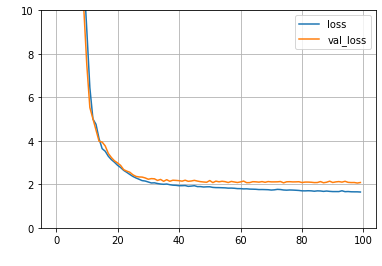

In [61]:
plot_loss(history)

In [62]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=1)

3/3 [==============================] - 0s 1000us/step - loss: 1.6666


## Performance

In [63]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.655987
linear_model,2.514683
dnn_horsepower_model,2.890415
dnn_model,1.666631


## Make Predictions

3/3 [==============================] - 0s 969us/step


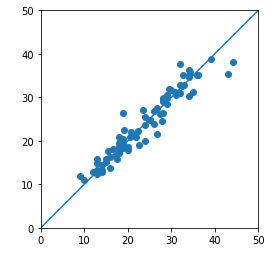

In [64]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values', color='white')
plt.ylabel('Predicted Values', color='white')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

plt.show()

**It looks like the model predicts reasonably well.** 

**Now take a look at the error distribution:**

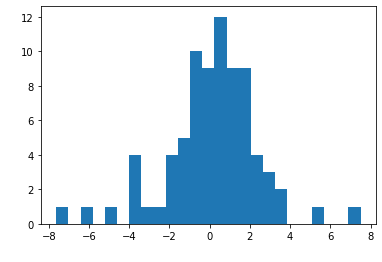

In [65]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]', color='white')
_ = plt.ylabel('Count', color='white')

save it for later use:

In [66]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model/assets


**Reload**

In [67]:
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(test_features, test_labels, verbose=1)

3/3 [==============================] - 0s 1ms/step - loss: 1.6666


In [68]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.655987
linear_model,2.514683
dnn_horsepower_model,2.890415
dnn_model,1.666631
reloaded,1.666631


* [Mean Squared Error (MSE)](https://www.tensorflow.org/api_docs/python/tf/losses/MeanSquaredError) and [Mean Absolute Error (MAE)](https://www.tensorflow.org/api_docs/python/tf/losses/MeanAbsoluteError) are common loss functions used for regression problems. Mean Absolute Error is less sensitive to outliers. Different loss functions are used for classification problems.
* Similarly, evaluation metrics used for regression differ from classification.
* When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.